### Contents
1. A simple Multi Logistic Perceptron (MLP) model 
2. Peform PCA dimensionality reduction -> A simple MLP model
3. Reformate features into 4D (No. samples, 8, 8, channels:margin,texture,shape) -> A simple CNN model
4. Does it make sense to perform CNN on these extracted features?
5. Performance summary

### Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
%matplotlib inline
import tensorflow as tf

/Users/Zhongyu/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### A simple MLP model

In [2]:
csv_data = pd.read_csv("../train.csv")

In [3]:
# extract species for numeric encoding 
species = sorted(csv_data.species.unique())
species_dict = {specie:index for index, specie in enumerate(species)}

In [4]:
all_data = csv_data.replace({'species':species_dict})

***
**Build a simple Neural Network using shape, margin, texture features to get a sense of performance**

**Split training set and testing set**

In [5]:
train_X, test_X, train_y, test_y = train_test_split(all_data.drop(['species'],axis=1), all_data['species'],
                                                    test_size=330, stratify=all_data['species'], random_state=916)

**Preprocess data**
 - center data and whiten X ??
 - one-hot-encode y
 - change data type

In [6]:
num_labels = len(species)

In [7]:
train_y_encode = np.arange(num_labels)==np.array(train_y)[:,None]
test_y_encode = np.arange(num_labels)==np.array(test_y)[:,None]

In [8]:
train_y_encode = train_y_encode.astype(np.float32)
test_y_encode = test_y_encode.astype(np.float32)

In [9]:
train_X_numpy = train_X.drop(['id'],axis=1).as_matrix().astype(np.float32)
test_X_numpy = test_X.drop(['id'],axis=1).as_matrix().astype(np.float32)

In [10]:
print "training set size:\t", train_X_numpy.shape, '\t', train_y_encode.shape
print "testing set size:\t", test_X_numpy.shape, '\t', test_y_encode.shape

training set size:	(660, 192) 	(660, 99)
testing set size:	(330, 192) 	(330, 99)


**Build the MLP model**

In [11]:
batch_size = 64
num_features = train_X_numpy.shape[1]
hidden_layer_size = 1024

In [12]:
def initialize(scope, shape, wt_initializer, center=True, scale=True):
    with tf.variable_scope(scope, reuse=None) as sp:
        wt = tf.get_variable("weights", shape, initializer=wt_initializer)
        bi = tf.get_variable("biases", shape[-1], initializer=tf.constant_initializer(1.))
        if center:
            beta = tf.get_variable("beta", shape[-1], initializer=tf.constant_initializer(0.0))
        if scale:
            gamma = tf.get_variable("gamma", shape[-1], initializer=tf.constant_initializer(1.0))
        moving_avg = tf.get_variable("moving_mean", shape[-1], initializer=tf.constant_initializer(0.0), \
                                     trainable=False)
        moving_var = tf.get_variable("moving_variance", shape[-1], initializer=tf.constant_initializer(1.0), \
                                     trainable=False)
        sp.reuse_variables()

In [18]:
init_lr = 0.001
graph = tf.Graph()
with graph.as_default():
    # prepare input 
    train_X_tf = tf.placeholder(tf.float32, shape=[batch_size, num_features])
    train_y_tf = tf.placeholder(tf.float32, shape=[batch_size, num_labels])
    valid_X_tf, valid_y_tf = tf.constant(test_X_numpy), tf.constant(test_y_encode)
    
    # initialize multi-layer parameters
    layers = [{'scope':'hidden_layer', 'shape':[num_features, hidden_layer_size], 
               'initializer':tf.contrib.layers.xavier_initializer()},
              {'scope':'output_layer', 'shape':[hidden_layer_size, num_labels],
               'initializer':tf.contrib.layers.xavier_initializer()}]
    for layer in layers:
        initialize(layer['scope'], layer['shape'], layer['initializer'])
    
    # build model
    def model(X, layer_scopes, is_training, keep_prob, decay=0.9):
        for scope in layer_scopes:
            with tf.variable_scope(scope, reuse=True):
                wt = tf.get_variable("weights")
                bi = tf.get_variable("biases")
            X = tf.matmul(X, wt) + bi
            # Batch Normalizaion
            X = tf.contrib.layers.batch_norm(X, decay=decay, center=True, scale=True, is_training=is_training,
                                            updates_collections=None, scope=scope, reuse=True)
            # ReLu Activation
            X = tf.nn.relu(X)
            # Dropout for non-output layers
            if scope!=layer_scopes[-1]:
                X = tf.nn.dropout(X, keep_prob)
        return X
    
    # setup a few parameters
    layer_scopes = [l['scope'] for l in layers]
    keep_prob = tf.placeholder(tf.float32)
    
    # compute log loss logloss = - 1/N*Sum(yij*log(pij)) -> yij is 1 if observation i is in class j otherwise 0
    train_logits = model(train_X_tf, layer_scopes, True, keep_prob)
    train_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(train_logits, train_y_tf))
    valid_logits = model(valid_X_tf, layer_scopes, False, keep_prob)
    valid_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(valid_logits, valid_y_tf))
    
    # setup optimizer
    global_step = tf.Variable(0)
    learning_rate = init_lr
    #tf.train.exponential_decay(init_lr, global_step, decay_steps=5000, decay_rate=0.5, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(train_loss, global_step=global_step)

In [19]:
num_steps = 20000
with tf.Session(graph=graph) as sess:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_y_encode.shape[0] - batch_size)
        batch_X = train_X_numpy[offset: (offset+batch_size), :]
        batch_y = train_y_encode[offset: (offset+batch_size), :]
        feed_dict = {train_X_tf: batch_X, train_y_tf: batch_y, keep_prob: 0.5}
        _, tloss = sess.run([optimizer, train_loss], feed_dict=feed_dict)
        if step%500==0:
            vloss = sess.run(valid_loss, feed_dict={keep_prob: 1.0})
            print('Epoch: %d:\tTrain Loss: %.6f\tValid Loss: %.6f' \
                %(step, tloss, vloss))
    print("Finished training")
    vloss = sess.run(valid_loss, feed_dict={keep_prob: 1.0})
    print("Final valid loss: %.6f" %(vloss))

Initialized
Epoch: 0:	Train Loss: 4.790440	Valid Loss: 5.207606
Epoch: 500:	Train Loss: 0.216396	Valid Loss: 0.371315
Epoch: 1000:	Train Loss: 0.151337	Valid Loss: 0.265029
Epoch: 1500:	Train Loss: 0.062914	Valid Loss: 0.220602
Epoch: 2000:	Train Loss: 0.036846	Valid Loss: 0.198779
Epoch: 2500:	Train Loss: 0.032600	Valid Loss: 0.189040
Epoch: 3000:	Train Loss: 0.030379	Valid Loss: 0.174750
Epoch: 3500:	Train Loss: 0.011336	Valid Loss: 0.173326
Epoch: 4000:	Train Loss: 0.010917	Valid Loss: 0.158479
Epoch: 4500:	Train Loss: 0.006091	Valid Loss: 0.166449
Epoch: 5000:	Train Loss: 0.013487	Valid Loss: 0.152830
Epoch: 5500:	Train Loss: 0.005009	Valid Loss: 0.142030
Epoch: 6000:	Train Loss: 0.004061	Valid Loss: 0.144878
Epoch: 6500:	Train Loss: 0.009779	Valid Loss: 0.140161
Epoch: 7000:	Train Loss: 0.003190	Valid Loss: 0.141918
Epoch: 7500:	Train Loss: 0.006575	Valid Loss: 0.140101
Epoch: 8000:	Train Loss: 0.003155	Valid Loss: 0.127327
Epoch: 8500:	Train Loss: 0.001443	Valid Loss: 0.122554
Ep

***
### Apply PCA to reduce input feature sizes and then build a simple MLP 

In [13]:
def pca_transform(train_X, test_X, feature, n_components):
    cols = [col for col in list(train_X.columns) if feature in col]
    train_feat = train_X[cols].as_matrix()
    test_feat = test_X[cols].as_matrix()
    train_avg = np.mean(train_feat, axis=0)
    test_avg = np.mean(test_feat, axis=0)
    train_feat = train_feat - train_avg
    test_feat = test_feat - test_avg
    pca_obj = PCA(n_components=n_components, whiten=True)
    pca_obj.fit(train_feat)
    print "total explained variance by ",n_components,'principle components: \t',sum(pca_obj.explained_variance_ratio_)
    train_transformed = pca_obj.transform(train_feat)
    test_transformed = pca_obj.transform(test_feat)
    return train_transformed, test_transformed

In [14]:
margin_train, margin_test = pca_transform(train_X, test_X, "margin", 8)

total explained variance by  8 principle components: 	0.807337883874


In [15]:
texture_train, texture_test = pca_transform(train_X, test_X, "texture", 10)

total explained variance by  10 principle components: 	0.745163550279


In [16]:
shape_train, shape_test = pca_transform(train_X, test_X, "shape",3)

total explained variance by  3 principle components: 	0.96344525651


In [17]:
train_X = np.concatenate([margin_train, texture_train, shape_train], axis=1)
test_X = np.concatenate((margin_test, texture_test, shape_test), axis=1)

**Simple preprocess data**

In [18]:
train_y_encode = np.arange(num_labels)==np.array(train_y)[:,None]
test_y_encode = np.arange(num_labels)==np.array(test_y)[:,None]

In [19]:
train_y_encode = train_y_encode.astype(np.float32)
test_y_encode = test_y_encode.astype(np.float32)

In [20]:
train_X_numpy = train_X.astype(np.float32)
test_X_numpy = test_X.astype(np.float32)

In [21]:
print("training set size: \t%s\t%s "%(train_X_numpy.shape, train_y_encode.shape))

training set size: 	(660, 21)	(660, 99) 


In [22]:
print "training set size:\t", train_X_numpy.shape, '\t', train_y_encode.shape
print "testing set size:\t", test_X_numpy.shape, '\t', test_y_encode.shape

training set size:	(660, 21) 	(660, 99)
testing set size:	(330, 21) 	(330, 99)


**PCA transformed simple MLP**

In [23]:
batch_size = 64
num_features = train_X_numpy.shape[1]
hidden_layer_size = 512

In [96]:
init_lr = 0.001
graph = tf.Graph()
with graph.as_default():
    # prepare input 
    train_X_tf = tf.placeholder(tf.float32, shape=[batch_size, num_features])
    train_y_tf = tf.placeholder(tf.float32, shape=[batch_size, num_labels])
    valid_X_tf, valid_y_tf = tf.constant(test_X_numpy), tf.constant(test_y_encode)
    
    # initialize multi-layer parameters
    layers = [{'scope':'hidden_layer', 'shape':[num_features, hidden_layer_size], 
               'initializer':tf.contrib.layers.xavier_initializer()},
              {'scope':'output_layer', 'shape':[hidden_layer_size, num_labels],
               'initializer':tf.contrib.layers.xavier_initializer()}]
    for layer in layers:
        initialize(layer['scope'], layer['shape'], layer['initializer'])
    
    # build model
    def model(X, layer_scopes, is_training, keep_prob, decay=0.9):
        for scope in layer_scopes:
            with tf.variable_scope(scope, reuse=True):
                wt = tf.get_variable("weights")
                bi = tf.get_variable("biases")
            X = tf.matmul(X, wt) + bi
            # Batch Normalizaion
            X = tf.contrib.layers.batch_norm(X, decay=decay, center=True, scale=True, is_training=is_training,
                                            updates_collections=None, scope=scope, reuse=True)
            # ReLu Activation
            X = tf.nn.relu(X)
            # Dropout for non-output layers
            if scope!=layer_scopes[-1]:
                X = tf.nn.dropout(X, keep_prob)
        return X
    
    # setup a few parameters
    layer_scopes = [l['scope'] for l in layers]
    keep_prob = tf.placeholder(tf.float32)
    
    # compute log loss logloss = - 1/N*Sum(yij*log(pij)) -> yij is 1 if observation i is in class j otherwise 0
    train_logits = model(train_X_tf, layer_scopes, True, keep_prob)
    train_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(train_logits, train_y_tf))
    valid_logits = model(valid_X_tf, layer_scopes, False, keep_prob)
    valid_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(valid_logits, valid_y_tf))
    
    # setup optimizer
    global_step = tf.Variable(0)
    learning_rate = init_lr
    #tf.train.exponential_decay(init_lr, global_step, decay_steps=5000, decay_rate=0.5, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(train_loss, global_step=global_step)

In [97]:
num_steps = 20000
with tf.Session(graph=graph) as sess:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        offset = (step * batch_size) % (train_y_encode.shape[0] - batch_size)
        batch_X = train_X_numpy[offset: (offset+batch_size), :]
        batch_y = train_y_encode[offset: (offset+batch_size), :]
        feed_dict = {train_X_tf: batch_X, train_y_tf: batch_y, keep_prob: 0.5}
        _, tloss = sess.run([optimizer, train_loss], feed_dict=feed_dict)
        if step%500==0:
            vloss = sess.run(valid_loss, feed_dict={keep_prob: 1.0})
            print('Epoch: %d:\tTrain Loss: %.6f\tValid Loss: %.6f' \
                %(step, tloss, vloss))
    print("Finished training")
    vloss = sess.run(valid_loss, feed_dict={keep_prob: 1.0})
    print("Final valid loss: %.6f" %(vloss))

Initialized
Epoch: 0:	Train Loss: 4.774050	Valid Loss: 5.166732
Epoch: 500:	Train Loss: 0.584475	Valid Loss: 0.535335
Epoch: 1000:	Train Loss: 0.386364	Valid Loss: 0.308883
Epoch: 1500:	Train Loss: 0.156146	Valid Loss: 0.234394
Epoch: 2000:	Train Loss: 0.127980	Valid Loss: 0.194028
Epoch: 2500:	Train Loss: 0.111867	Valid Loss: 0.172991
Epoch: 3000:	Train Loss: 0.083919	Valid Loss: 0.162677
Epoch: 3500:	Train Loss: 0.044651	Valid Loss: 0.147828
Epoch: 4000:	Train Loss: 0.046696	Valid Loss: 0.138724
Epoch: 4500:	Train Loss: 0.026203	Valid Loss: 0.133726
Epoch: 5000:	Train Loss: 0.046897	Valid Loss: 0.132117
Epoch: 5500:	Train Loss: 0.019093	Valid Loss: 0.124316
Epoch: 6000:	Train Loss: 0.016064	Valid Loss: 0.127078
Epoch: 6500:	Train Loss: 0.044346	Valid Loss: 0.119865
Epoch: 7000:	Train Loss: 0.016474	Valid Loss: 0.116237
Epoch: 7500:	Train Loss: 0.014166	Valid Loss: 0.120500
Epoch: 8000:	Train Loss: 0.010739	Valid Loss: 0.117436
Epoch: 8500:	Train Loss: 0.008504	Valid Loss: 0.109569
Ep

***
### Simple CNN

In [24]:
import sys
sys.path.append("/Users/Zhongyu/Documents/projects/CNNplayground/")
from cnn import *

In [25]:
train_X, test_X, train_y, test_y = train_test_split(all_data.drop(['species'],axis=1), all_data['species'],
                                                    test_size=330, stratify=all_data['species'], random_state=916)

**Prepare input data for CNN**

In [26]:
# One-Hot-Encode y
train_y_encode = np.arange(num_labels)==np.array(train_y)[:,None]
test_y_encode = np.arange(num_labels)==np.array(test_y)[:,None]
train_y_encode = train_y_encode.astype(np.float32)
test_y_encode = test_y_encode.astype(np.float32)

In [27]:
def reshape_feature(X_df, feature, order='F'):
    cols = [col for col in list(X_df.columns) if feature in col]
    selected_cols = X_df[cols].as_matrix()
    reshaped_cols = selected_cols.reshape((X_df.shape[0], 8,8), order=order)
    return reshaped_cols.astype(np.float32)

In [28]:
train_margin = reshape_feature(train_X, 'margin')
train_texture = reshape_feature(train_X, 'texture')
train_shape = reshape_feature(train_X, 'shape')

In [29]:
test_margin = reshape_feature(test_X, 'margin')
test_texture = reshape_feature(test_X, 'texture')
test_shape = reshape_feature(test_X, 'shape')

In [30]:
train_X_numpy = np.concatenate((train_margin[:,:,:,None], train_texture[:,:,:,None], train_shape[:,:,:,None]), axis=3)
test_X_numpy = np.concatenate((test_margin[:,:,:,None], test_texture[:,:,:,None], test_shape[:,:,:,None]), axis=3)

In [31]:
print "training set size:\t", train_X_numpy.shape, '\t', train_y_encode.shape
print "testing set size:\t", test_X_numpy.shape, '\t', test_y_encode.shape

training set size:	(660, 8, 8, 3) 	(660, 99)
testing set size:	(330, 8, 8, 3) 	(330, 99)


**Simple CNN**

In [53]:
batch_size = 64
input_shape = [batch_size, 8, 8, 3]
conv_depth = 3

In [54]:
model = cnn_graph(input_shape, num_labels)
model.setup_data(batch_size, valid_X=test_X_numpy, valid_y=test_y_encode)
#conv_wt_initializer = tf.truncated_normal_initializer(stddev=0.10)
conv_wt_initializer = tf.contrib.layers.xavier_initializer_conv2d()
conv_layer = ('conv1', 5)

# Convolutional layer
layer_name, filter_size = conv_layer[0], conv_layer[1]
model.add_convIncept_layer(layer_name, conv_depth, conv_wt_initializer, add_output_summary=False)
model.add_batchnorm_layer(layer_name+'/batchnorm', add_output_summary=False)
model.add_act_layer(layer_name+'/activation')
#model.add_pool_layer(layer_name+'/pool')

# Fully Connected layer
fc_layers = [('fc1', 3096), ('fc2', num_labels)]
fc_wt_initializer = tf.contrib.layers.variance_scaling_initializer()
for fc_layer in fc_layers:
    layer_name, num_neuron = fc_layer[0], fc_layer[1]
    model.add_fc_layer(layer_name, num_neuron, fc_wt_initializer, add_output_summary=False)
    model.add_batchnorm_layer(layer_name+'/batchnorm', add_output_summary=False)
    model.add_act_layer(layer_name+'/activation')
    if layer_name!=fc_layers[-1][0]:
        model.add_dropout_layer(layer_name+'/dropout')

# Setup learning rate and optimizer
model.setup_learning_rate(0.0005, exp_decay=False, add_output_summary=False)
train_loss = model.compute_train_loss(add_output_summary=False)
valid_loss = model.compute_valid_loss(add_output_summary=False)
optimizer = model.setup_optimizer(tf.train.AdamOptimizer, add_output_summary=False)

In [55]:
# Start a session
graph = model.get_graph()
training_steps = 20000
with tf.Session(graph=graph) as sess:
    tf.initialize_all_variables().run()
    print("initialized")
    model.set_kp_value('fc1/dropout', 0.3)
    train_feed_dict = model.get_kp_collection_dict()
    for step in range(training_steps):
        offset = (step*batch_size)%(train_X.shape[0]-batch_size)
        batch_X = train_X_numpy[offset:(offset+batch_size),:,:,:]
        batch_y = train_y_encode[offset:(offset+batch_size),:]
        train_feed_dict.update({model.train_X : batch_X,
                                model.train_y : batch_y})
        _, tloss = sess.run([optimizer, train_loss], feed_dict=train_feed_dict)
        if step%500 == 0:
            vloss = sess.run(valid_loss, feed_dict=model.kp_reference_feed_dict)
            print('Epoch: %d:\tTrain Loss: %.6f\tValid Loss: %.6f' \
                %(step, tloss, vloss))
    print("Finished training")
    vloss = sess.run(valid_loss, feed_dict=model.kp_reference_feed_dict)
    print("Final valid loss: %.6f" %(vloss))

initialized
Epoch: 0:	Train Loss: 4.687462	Valid Loss: 5.933039
Epoch: 500:	Train Loss: 0.317869	Valid Loss: 0.502233
Epoch: 1000:	Train Loss: 0.261912	Valid Loss: 0.359931
Epoch: 1500:	Train Loss: 0.100258	Valid Loss: 0.304645
Epoch: 2000:	Train Loss: 0.074369	Valid Loss: 0.274471
Epoch: 2500:	Train Loss: 0.071608	Valid Loss: 0.248939
Epoch: 3000:	Train Loss: 0.061883	Valid Loss: 0.231094
Epoch: 3500:	Train Loss: 0.028847	Valid Loss: 0.220732
Epoch: 4000:	Train Loss: 0.030065	Valid Loss: 0.202459
Epoch: 4500:	Train Loss: 0.014444	Valid Loss: 0.194165
Epoch: 5000:	Train Loss: 0.036387	Valid Loss: 0.180580
Epoch: 5500:	Train Loss: 0.013982	Valid Loss: 0.172070
Epoch: 6000:	Train Loss: 0.011299	Valid Loss: 0.168818
Epoch: 6500:	Train Loss: 0.017824	Valid Loss: 0.164777
Epoch: 7000:	Train Loss: 0.008264	Valid Loss: 0.153415
Epoch: 7500:	Train Loss: 0.009942	Valid Loss: 0.140054
Epoch: 8000:	Train Loss: 0.007537	Valid Loss: 0.140604
Epoch: 8500:	Train Loss: 0.004521	Valid Loss: 0.138688
Ep

### Would it make sense to apply CNN on extracted-features/non-image? Visulization

In [34]:
leaf0name = [k for k, v in species_dict.items() if v==0]
leaf1name = [k for k, v in species_dict.items() if v==1]
leaf14name = [k for k, v in species_dict.items() if v==14]

In [35]:
print leaf0name
print leaf1name
print leaf14name

['Acer_Capillipes']
['Acer_Circinatum']
['Alnus_Viridis']


In [36]:
leaf0bool = train_y==0
leaf1bool = train_y==1
leaf14bool = train_y==14

In [37]:
leaf0index = np.where(leaf0bool)
leaf1index = np.where(leaf1bool)
leaf14index = np.where(leaf14bool)

In [38]:
leaf0samples = np.squeeze(train_X_numpy[leaf0index,:,:,:], axis=0)
leaf1samples = np.squeeze(train_X_numpy[leaf1index,:,:,:], axis=0)
leaf14samples = np.squeeze(train_X_numpy[leaf14index,:,:,:], axis=0)

In [47]:
def plot_as_RGB(leaf0, leaf1, leaf0name, leaf1name):
    max_col = 7
    title=leaf0name+"(top) vs. "+leaf1name+"(bottom)"
    for i in range(1, max_col*2+1):
        plt.subplot(2, max_col, i)
        if i<=max_col:
            sample = leaf0samples[i-1,:,:,:]
        else:
            sample = leaf1samples[i-max_col-1,:,:,:]
        sampleRGB = sample*255
        plt.imshow(sampleRGB)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

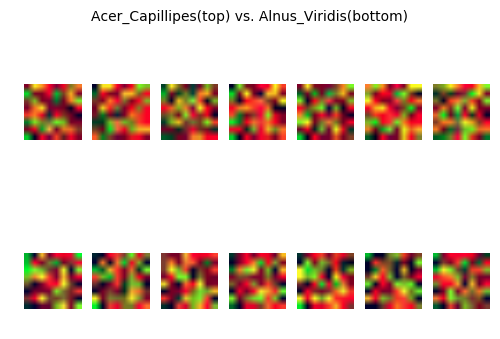

In [48]:
plot_as_RGB(leaf0samples, leaf14samples, leaf0name[0], leaf14name[0])

In [57]:
def plot_as_gray(leaf0, leaf1, leaf2, channel, leaf0name, leaf1name, leaf2name):
    max_col = 7
    title=leaf0name+"(top) vs. "+leaf1name+"(middle) vs. "+leaf2name+"(bottom)"
    for i in range(1, max_col*3+1):
        plt.subplot(3, max_col, i)
        if i<=max_col:
            sample = leaf0[i-1,:,:,:]
        elif i<=2*max_col:
            sample = leaf1[i-max_col-1,:,:,:]
        else:
            sample = leaf2[i-2*max_col-1,:,:,:]
        sampleRGB = sample*255
        sampleGray = sampleRGB[:,:,channel]
        plt.imshow(sampleGray, cmap=plt.cm.gray)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

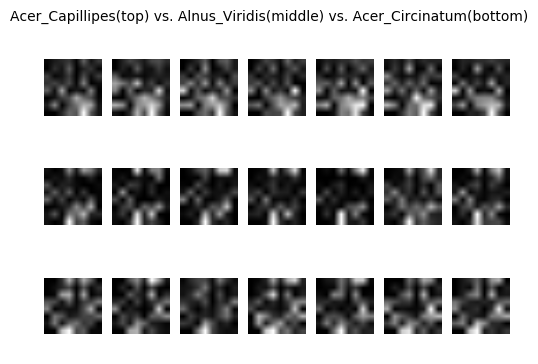

In [58]:
plot_as_gray(leaf0samples, leaf14samples, leaf1samples, 0, leaf0name[0], leaf14name[0], leaf1name[0])

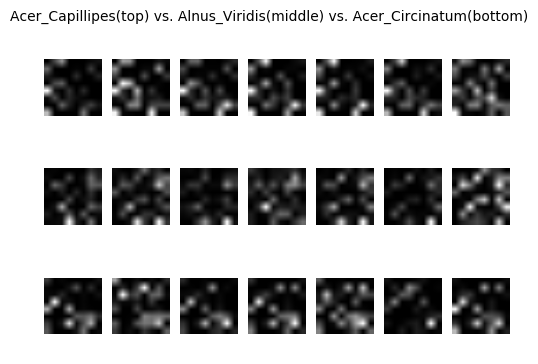

In [59]:
plot_as_gray(leaf0samples, leaf14samples, leaf1samples, 1, leaf0name[0], leaf14name[0], leaf1name[0])

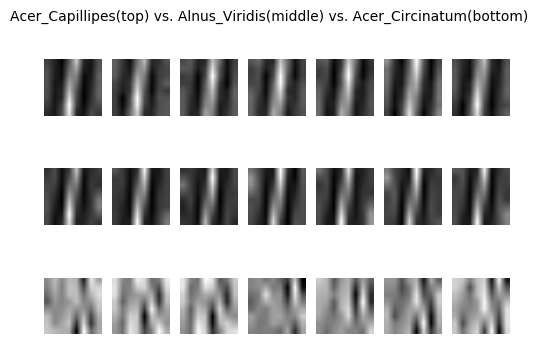

In [60]:
plot_as_gray(leaf0samples, leaf14samples, leaf1samples, 2, leaf0name[0], leaf14name[0], leaf1name[0])

**Although treating 3D reshaped extracted features as RGB directly and plotting it out, the pattern is not obvious, plotting out the image channel by channel gives a more apparent hidden pattern between different species.**

***
### Performance Summary

| Models     | Preprocess | No. Features| Architecture |Epoches | Learning Rate| Dropout | Performance |
| -----------|:-----------| :-----:| :----:|
| Simple MLP | None       | 128|->FC(1024)->FC Softmax|20000|0.001|0.5|0.1003|
| PCA MLP    | PCA white  | 21 |->FC(512)->FC Softmax|20000|0.001|0.5|0.1022|
| Simple CNN | None       | 8x8x3|->ConvIncept->FC(3096)->FC Softmax|20000|0.0005|0.3|0.1041|

**Note**: 
- FC layer - FC->BN->ReLu->Dropout (unless output layer)
- Conv layer - Conv -> BN -> ReLu -> (possibly MaxPool or AvgPool)

**Conclusions**
- When the data is in the right form and nature, it is possible to employ CNN family even if data is not image data
- The simplest form of MLP and CNN seems to perform similarally in the extracted features. However, MLP model with PCA preprocess has the lowest model complexity.
